# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [45]:
RANDOM_STATE=12345
import pandas as pd
import datetime as dt
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, confusion_matrix, mean_squared_error, precision_score, recall_score, f1_score, classification_report, roc_curve, precision_recall_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from sklearn.utils import shuffle
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [46]:
# Импорт данных 
try:
    df1=pd.read_csv('/datasets/geo_data_0.csv')
    df2=pd.read_csv('/datasets/geo_data_1.csv')
    df3=pd.read_csv('/datasets/geo_data_2.csv')
except:
    df1=pd.read_csv(r'C:\Users\Admin\Desktop\Oild\geo_data_0.csv')
    df2=pd.read_csv(r'C:\Users\Admin\Desktop\Oild\geo_data_1.csv')
    df3=pd.read_csv(r'C:\Users\Admin\Desktop\Oild\geo_data_2.csv')

In [47]:
#Функция вывода инфы о массиве первые и последние 5 строк
def headtail(df_name):
    display('Head 5')
    display(df_name.head(5))
    display('Tail 5')
    display(df_name.tail(5))

Приступим к анализу данных. Рассмотрим первые и последние 5 строк каждого массива

In [48]:
headtail(df1)

'Head 5'

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


'Tail 5'

,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246


In [49]:
headtail(df2)

'Head 5'

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


'Tail 5'

,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103


In [50]:
headtail(df3)

'Head 5'

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


'Tail 5'

,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767


Пояснение к полям:

id — уникальный идентификатор скважины;
f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
product — объём запасов в скважине (тыс. баррелей).

f0	f1	f2	- фичи, вероятно после шифрования, либо это координаты, но тоже в зашифрованом виде

Рассмотрим дополнительные свойства 

In [51]:
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [52]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


In [53]:
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None


Исходные массивы имеют 100000 строк.Количество данных, типы данных совпадают. 

Добавим поля, которые отвечают за группу, например, A,B,C для каждого df

In [54]:
#Функция добавления категории к массиву
def cat(df_name1,df_name2,df_name3):
    df_name1['category']='A'
    df_name2['category']='B'
    df_name3['category']='C'

In [55]:
cat(df1,df2,df3)

#AB,AC,BC, df1,df2 df1,df3  df2,df3

Для данной задачи имеются следующие ограничения и условия:

1. Для обучения модели подходит только линейная регрессия, поскольку другие модели не обеспечивают достаточную предсказуемость в данном контексте.

2. При разведке каждого региона исследуют 500 месторождений, и с использованием машинного обучения выбирают 200 наилучших для разработки.

3. Бюджет на разработку скважин в каждом регионе составляет 10 миллиардов рублей.

4. При текущих ценах один баррель сырья приносит доход в размере 450 рублей. Доход с каждой единицы продукции составляет 450 тысяч рублей, так как объём указан в тысячах баррелей.

5. Регион считается убыточным, если сумма дохода от разработки не превысила бюджет или равна бюджету. В противном случае, регион считается прибыльным.

6. Данные, используемые в задаче, являются синтетическими, и детали контрактов и характеристики месторождений не разглашаются.

Основной задачей является выбор региона для разработки, который максимизирует прибыль и при этом имеет риск убытков менее 2.5%.


 Убытком считается ситуация, когда сумма дохода от разработки скважин не превышает бюджет или равна бюджету. Если сумма дохода превышает бюджет, то это считается прибылью.


**Вывод**

Так как  у нас нет информации о стоимости, бюджете, и других дополнительных параметрах для каждой скважины в регионе, и предоставлены только группы A, B и C, то мы можем рассматривать задачу как задачу классификации с тремя классами: A, B и C. Нашей целью будет предсказать, к какой из этих групп будет относиться каждая скважина.

Для этого нам необходимо провести анализ и исследование данных, чтобы выявить признаки, которые могли бы помочь в классификации скважин по группам. Мы также можем использовать различные методы машинного обучения, такие как логистическая регрессия, случайный лес, или метод опорных векторов, чтобы построить модель классификации на основе имеющихся данных о скважинах.

После построения модели мы сможем предсказать, к какой из групп (A, B или C) относится каждая скважина в регионе, и таким образом определить, в каком регионе стоит добывать нефть, чтобы максимизировать прибыль и снизить риски убытков.

In [56]:
#AB,AC,BC, df1,df2  df1,df3  df2,df3
#Функция визуализации данных
def visual_part2(df_1,df_2):
    print('f0 distribution')
    a=plt.hist([df_1['f0'], df_2['f0']],bins = 30,
             color =('pink','blue'),label=("1 f0", "2 f0"))
    plt.xlabel("f0")
    plt.ylabel("Количество f0")
    
    plt.legend(loc='best')
    plt.show()
    
    print('f1 distribution')
    plt.hist([df_1['f1'], df_2['f1']],bins = 30,color =('pink','blue'),label=("1 f1", "2 f1"))
    plt.xlabel("f1")
    plt.ylabel("Количество f1")
    plt.legend(loc='best')
    plt.show()
    
    print('f2 distribution')
    plt.hist([df_1['f2'], df_2['f2']],bins = 30,color =('pink','blue'),
             label=("1 f2", "2 f2"))
    plt.xlabel("f2")
    plt.ylabel("Количество f2")
    plt.legend(loc='best')
    plt.show()
    
    print('product distribution')
    plt.hist([df_1['product'], df_2['product']],bins = 30,color =('pink','blue'),
             label=("1 product", "2 product"))
    plt.xlabel("product")
    plt.ylabel("Количество product")
    plt.legend(loc='best')
    plt.show()
    
    
   
    
   

f0 distribution


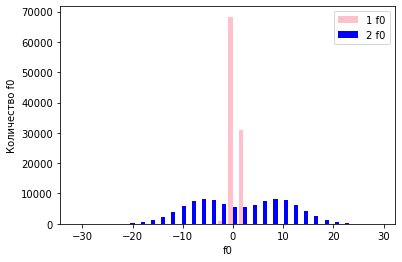

f1 distribution


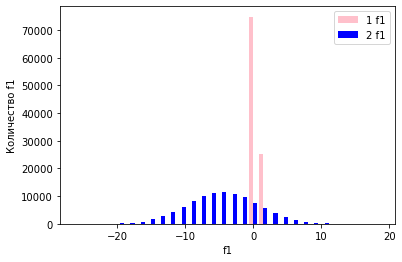

f2 distribution


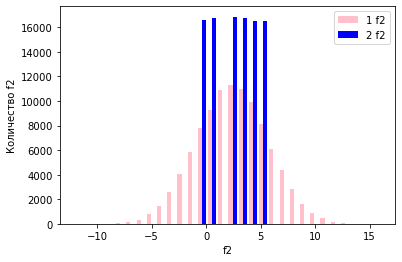

product distribution


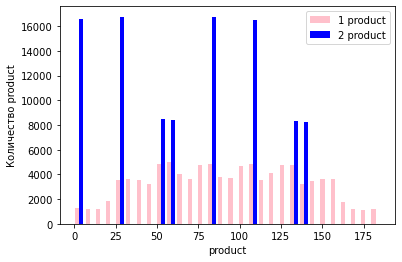

In [57]:
visual_part2(df1,df2)

Наблюдаем несоглассованность признаков  для категорий AB ( df1,df2), значения признаков в B превышают количественно признаков A

Перейдем к следующей группе AC (df1,df3)

f0 distribution


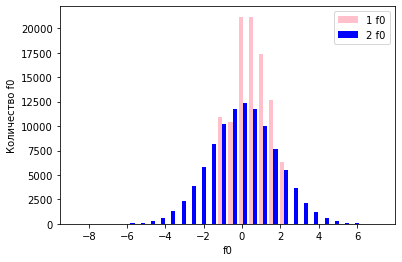

f1 distribution


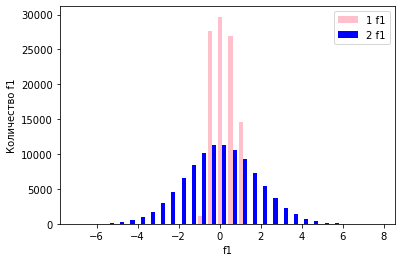

f2 distribution


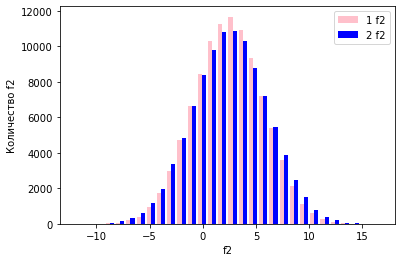

product distribution


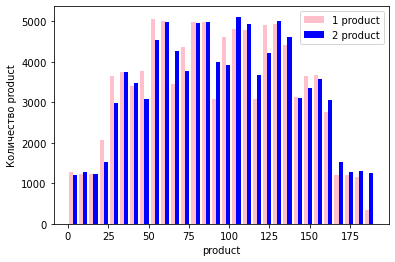

In [58]:
visual_part2(df1,df3)

В данном случае AC (df1,df3) ситация немного лучше по критериям product, f2 эквивалентны, по критерию f0 и f1 наблюдается
количественный сдвиг в сторону df3.

Также признаки f0 и f1 будут иметь взаимосвязь, что плохо скажется на модели.

Позднее проверим по корелляции признаков

Рассмотрим случай BC (df2,df3)

f0 distribution


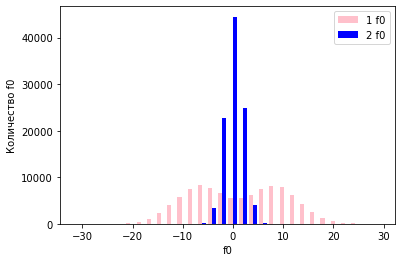

f1 distribution


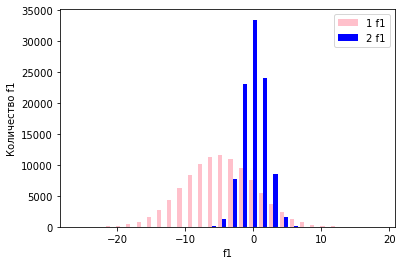

f2 distribution


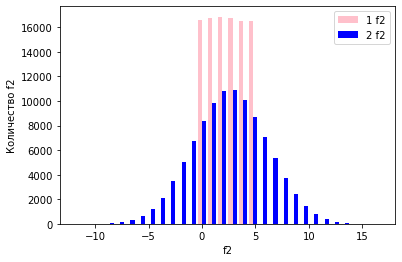

product distribution


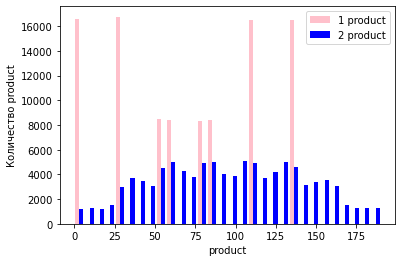

In [59]:
visual_part2(df2,df3)

**Вывод**

**AB (df1, df2):** Наблюдается несогласованность признаков, где значения признаков в B превышают количественно признаки в A. Это может указывать на различия в данных между этими двуми категориями, и это может потребовать дополнительного анализа.

**AC (df1, df3):** В данном случае ситуация немного лучше по критериям product и f2, которые эквивалентны между df1 и df3. Однако, по критериям f0 и f1 наблюдается количественный сдвиг в сторону df3. Также стоит учесть, что признаки f0 и f1 могут иметь взаимосвязь, что потенциально может повлиять на модель. Эти аспекты будут учтены при дальнейшем анализе, включая корреляционный анализ.

**BC (df2, df3):** В этом случае также наблюдается смещение в сторону массива df3. Это может указывать на различия между этими двуми категориями, и для дальнейшего анализа данных можно воспользоваться сбросом по межквартильному размаху (IQR) для соответствующих признаков.

**Воспользуемся сбросом по IQR для данных признаков**

In [60]:
# Функция вывода пределов для сброса по методу IQR принимает на вход массив.describe() из числовых значений
# Рекомендация  использовать значения типа float | int 
# индекс- колонка с названием исходного столбца 
def iqr(stat_df_describe):
    stat_df_describe=pd.DataFrame(stat_df_describe.describe())
    stat_df_describe=stat_df_describe.reset_index(drop=True)
    top_limit=[]
    bot_limit=[]
    columns_lst=[]
    for value in stat_df_describe.columns:
        limit_up=stat_df_describe[value][6]+1.5*(stat_df_describe[value][6]-stat_df_describe[value][4])
        limit_low=stat_df_describe[value][4]-1.5*(stat_df_describe[value][6]-stat_df_describe[value][4])
        top_limit.append(limit_up)
        
        bot_limit.append(limit_low)
        columns_lst.append(value)
        dictionary={'Columns':columns_lst, 'Top_limit':top_limit,'Bot_limit':bot_limit}
        a=pd.DataFrame(dictionary)
                
        
    return a

In [61]:
df_lim1=iqr(df1)
df_lim2=iqr(df2)
df_lim3=iqr(df3)

In [62]:
display(df_lim1)

,Columns,Top_limit,Bot_limit
0,f0,2.792824,-1.791823
1,f1,2.052938,-1.553173
2,f2,11.356098,-6.353261
3,product,236.663962,-51.602367


In [63]:
def intrest_df(df_intrest,df_limit):
    intrest_df_intrest=df_intrest[(df_intrest['f0']<df_limit['Top_limit'][0])&
                        (df_intrest['f0']>=df_limit['Bot_limit'][0])&
                        (df_intrest['f1']<df_limit['Top_limit'][1])&
                        (df_intrest['f1']>=df_limit['Bot_limit'][1])&
                        (df_intrest['f2']<df_limit['Top_limit'][2])&
                        (df_intrest['f2']>=df_limit['Bot_limit'][2])&
                        (df_intrest['product']<df_limit['Top_limit'][3])&
                        (df_intrest['product']>=df_limit['Bot_limit'][3])]
    return intrest_df_intrest

In [64]:
df_intrest1=intrest_df(df1,df_lim1)
df_intrest2=intrest_df(df2,df_lim2)
df_intrest3=intrest_df(df3,df_lim3)


In [65]:
display(df_intrest1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99494 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        99494 non-null  object 
 1   f0        99494 non-null  float64
 2   f1        99494 non-null  float64
 3   f2        99494 non-null  float64
 4   product   99494 non-null  float64
 5   category  99494 non-null  object 
dtypes: float64(4), object(2)
memory usage: 5.3+ MB


None

Рассмотрим корелляцию между критериями для каждого региона

In [66]:
df_intrest1.columns

Index(['id', 'f0', 'f1', 'f2', 'product', 'category'], dtype='object')

In [67]:
numeric_columns=['f0', 'f1', 'f2', 'product']

In [68]:
categorical_columns=['category']

In [69]:
#дропаем дубликаты
df_intrest1=df_intrest1.drop_duplicates()
df_intrest2=df_intrest2.drop_duplicates()
df_intrest3=df_intrest3.drop_duplicates()

In [70]:
#дропаем id

df_intrest1=df_intrest1.drop('id',axis=1)
df_intrest2=df_intrest2.drop('id',axis=1)
df_intrest3=df_intrest3.drop('id',axis=1)

Корелляционная матрица phik для региона A


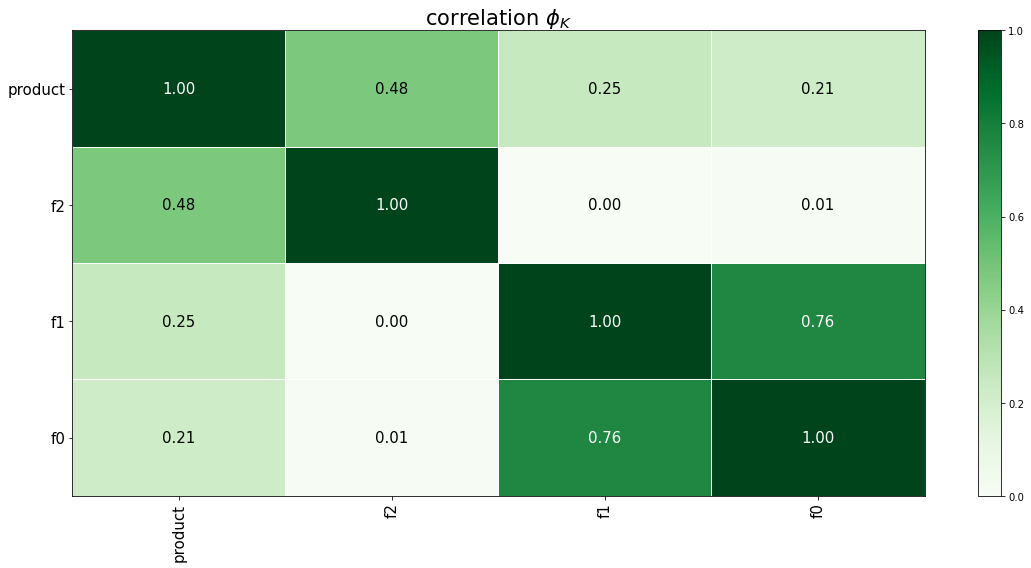

In [71]:
# корр матрица phik 
print('Корелляционная матрица phik для региона A')
phik_corrs = df_intrest1.phik_matrix(interval_cols=numeric_columns)
plot_correlation_matrix(phik_corrs.values, 
                        x_labels=phik_corrs.columns, 
                        y_labels=phik_corrs.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

**Рассмотрим взаимосвязь между критериями для первого региона A**


критерий f0 созависим с критерием f1, величина корреляции составляет 0.76
для целевого критерия product наблюдается зависимость от параметра f2, величина корреляции составляет 0.48

Корелляционная матрица phik для региона B


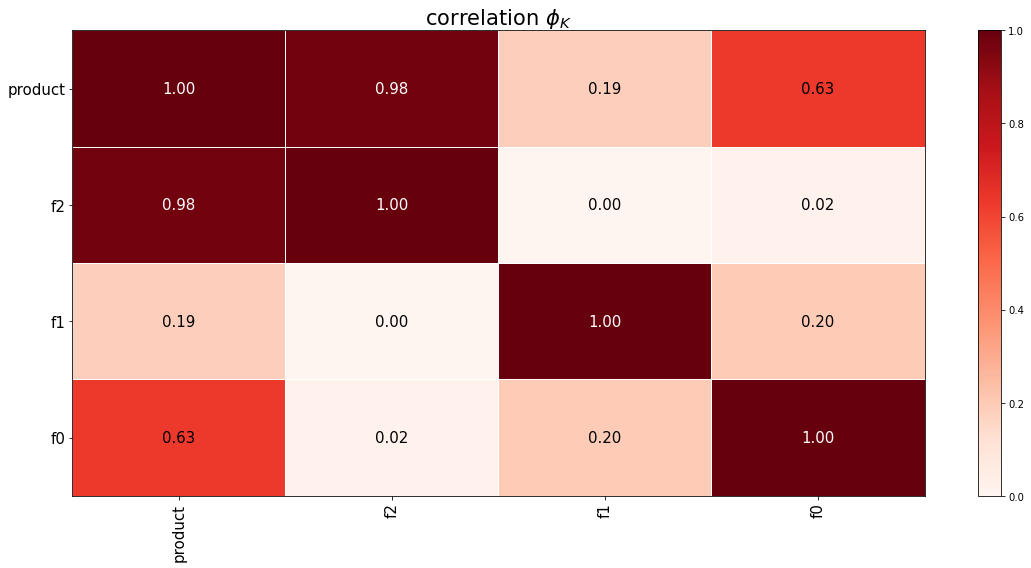

In [72]:
# корр матрица phik 
print('Корелляционная матрица phik для региона B')
phik_corrs = df_intrest2.phik_matrix(interval_cols=numeric_columns)
plot_correlation_matrix(phik_corrs.values, 
                        x_labels=phik_corrs.columns, 
                        y_labels=phik_corrs.index, 
                        vmin=0, vmax=1, color_map="Reds", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

**Рассмотрим взаимосвязь между критериями для региона B**

для целевого критерия product наблюдается зависимость от параметра f2(0.98) и f0(0.63)

Корелляционная матрица phik для региона С


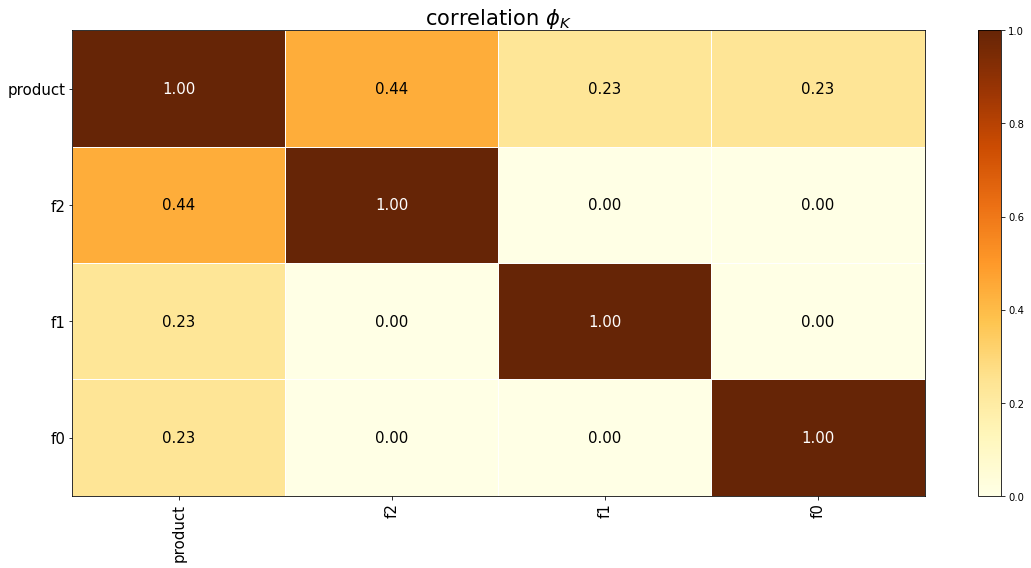

In [73]:
# корр матрица phik 
print('Корелляционная матрица phik для региона С')
phik_corrs = df_intrest3.phik_matrix(interval_cols=numeric_columns)
plot_correlation_matrix(phik_corrs.values, 
                        x_labels=phik_corrs.columns, 
                        y_labels=phik_corrs.index, 
                        vmin=0, vmax=1, color_map="YlOrBr", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

**Рассмотрим взаимосвязь между критериями для региона С**

для целевого критерия product наблюдается зависимость от параметра f2(0.44) 

In [74]:
df_abc=pd.concat([df_intrest1,df_intrest2,df_intrest3])

In [75]:
print('Размер объединенного массива до сброса по IQR',df_abc.shape)

Размер объединенного массива до сброса по IQR (296861, 5)


Корелляционная матрица phik для объединеного массива


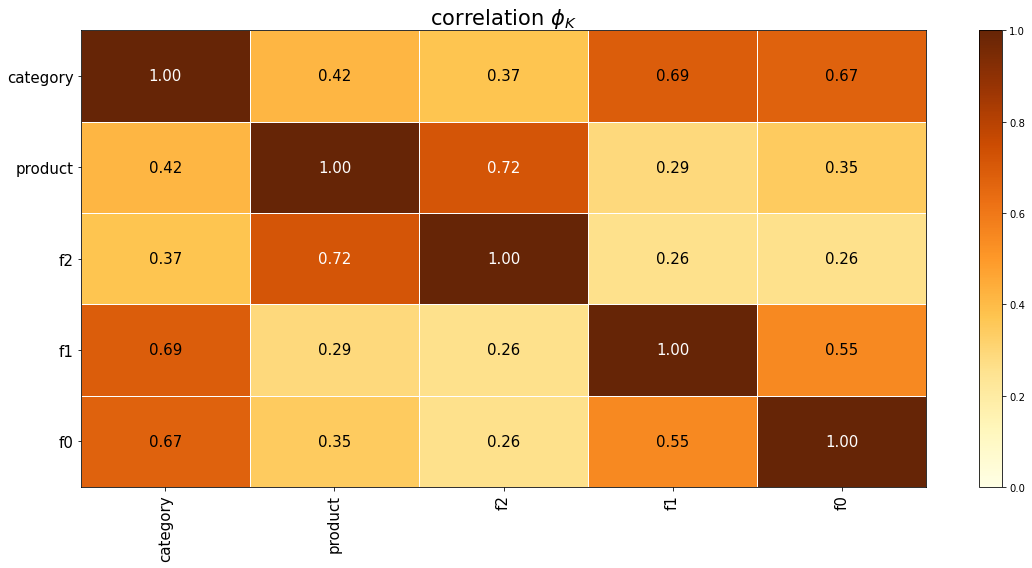

In [76]:
# корр матрица phik 
print('Корелляционная матрица phik для объединеного массива')
phik_corrs = df_abc.phik_matrix(interval_cols=numeric_columns)
plot_correlation_matrix(phik_corrs.values, 
                        x_labels=phik_corrs.columns, 
                        y_labels=phik_corrs.index, 
                        vmin=0, vmax=1, color_map="YlOrBr", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

**Рассмотрим взаимосвязь между критериями для объединенного массива ABС**

Параметр category зависит от критериев f0(0.67),f1(0.69)
Для целевого критерия product наблюдается зависимость от параметра f2(0.72) 
Параметр f1 зависит от параметра f0 (0.55)


In [77]:
standart_data=df_abc
#standart_data=standart_data.drop(['id'],axis=1)

In [78]:
standart_data.columns

Index(['f0', 'f1', 'f2', 'product', 'category'], dtype='object')

Засплитуем standart_data обратно по регионам на st_df1,st_df2,st_df3 по полю category

In [79]:
st_df1=standart_data[standart_data['category']=='A']
st_df2=standart_data[standart_data['category']=='B']
st_df3=standart_data[standart_data['category']=='C']

Посмотрим на размеры классов по регионам

In [80]:
print('Размер класса А',st_df1.shape[0])
print('Размер класса B',st_df2.shape[0])
print('Размер класса C',st_df3.shape[0])

Размер класса А 99494
Размер класса B 99363
Размер класса C 98004


Величина дисбаланса незначительна

А теперь про деньги, введем новый столбец, назовем его crops=product*450 (объём запасов в скважине (тыс. баррелей) x 450 рублей)

In [81]:
standart_data['crops']=standart_data['product']*450

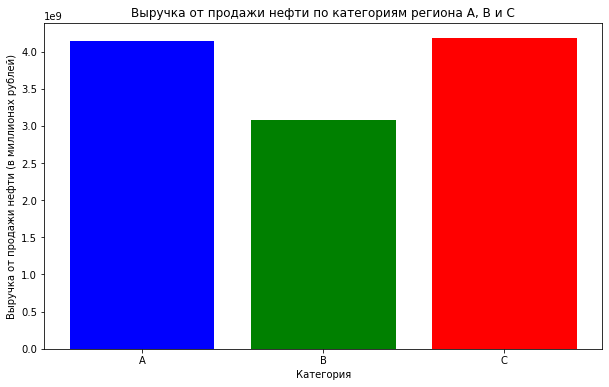

In [82]:
# Группируем данные по категориям A, B и C и вычисляем суммарную выручку для каждой категории
revenue_by_category = standart_data.groupby('category')['crops'].sum()

# Создаем гистограмму
plt.figure(figsize=(10, 6))
plt.bar(revenue_by_category.index, revenue_by_category.values, color=['blue', 'green', 'red'])
plt.xlabel('Категория')
plt.ylabel('Выручка от продажи нефти (в миллионах рублей)')
plt.title('Выручка от продажи нефти по категориям региона A, B и C')
plt.xticks(revenue_by_category.index, ['A', 'B', 'C'])
plt.show()

## Вывод  по блоку Подготовка данных

Учитывая ограниченность информации о стоимости, бюджете и дополнительных параметрах для каждой скважины в регионе, мы рассматриваем задачу классификации с тремя классами: A, B и C. Нашей целью является предсказание, к какой из этих групп (A, B или C) относится каждая скважина в регионе. Это позволит нам определить, в каком регионе стоит добывать нефть, чтобы максимизировать прибыль и снизить риски убытков.

Анализ сравнительных данных между группами:
- Группа AB (df1, df2): Наблюдается несогласованность признаков, где значения признаков в B превышают количественно признаки в A. Это может указывать на различия в данных между этими двумя категориями и потребовать дополнительного анализа.
- Группа AC (df1, df3): В данном случае ситуация немного лучше по критериям product и f2, которые эквивалентны между df1 и df3. Однако, по критериям f0 и f1 наблюдается количественный сдвиг в сторону df3. Также стоит учесть, что признаки f0 и f1 могут иметь взаимосвязь, что потенциально может повлиять на модель. Эти аспекты будут учтены при дальнейшем анализе, включая корреляционный анализ.
- Группа BC (df2, df3): В этом случае также наблюдается смещение в сторону массива df3. Это может указывать на различия между этими двуми категориями, и для дальнейшего анализа данных можно воспользоваться сбросом по межквартильному размаху (IQR) для соответствующих признаков.

Выбранные признаки:
- Числовые признаки: 'f0', 'f1', 'f2', 'product'
- Категориальный признак: 'category'

Удален признак 'id'.

Корреляционный анализ для регионов:
- Регион A: Критерий f0 коррелирует с критерием f1 (коэффициент корреляции 0.76), а также с целевым критерием product (коэффициент корреляции 0.48).
- Регион B: Для целевого критерия product наблюдается зависимость от параметра f2 (коэффициент корреляции 0.98) и f0 (коэффициент корреляции 0.63).
- Регион C: Для целевого критерия product наблюдается зависимость от параметра f2 (коэффициент корреляции 0.44).


**взаимосвязь между критериями для объединенного массива ABС**

- Параметр category зависит от критериев f0(0.67),f1(0.69)
- Для целевого критерия product наблюдается зависимость от параметра f2(0.72) 
- Параметр f1 зависит от параметра f0 (0.55)



Понятно, что в данном случае прибыль будет зависеть от величины product, и мы можем построить модель, которая предсказывает эту величину. Бюджет служит ограничением, позволяющим нам отсеять те скважины, у которых произведение product на стоимость не превышает бюджет. Для удобства обозначим данные как `standart_data = df_abc.
Эти аспекты будут учтены при построении моделей классификации для определения категорий скважин в каждом регионе.



## Формирование X_train, X_valid, y_train, y_valid

In [83]:
standart_data

,f0,f1,f2,product,category,crops
0,0.705745,-0.497823,1.221170,105.280062,A,47376.027830
1,1.334711,-0.340164,4.365080,73.037750,A,32866.987619
2,1.022732,0.151990,1.419926,85.265647,A,38369.541209
3,-0.032172,0.139033,2.978566,168.620776,A,75879.349000
4,1.988431,0.155413,4.751769,154.036647,A,69316.491032
...,...,...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046,C,77547.170779
99996,-1.261523,-0.894828,2.524545,138.748846,C,62436.980603
99997,-1.199934,-2.957637,5.219411,157.080080,C,70686.035887
99998,-2.419896,2.417221,-5.548444,51.795253,C,23307.863847


In [84]:
# Разбиваем данные на матрицу признаков X и вектор целевой переменной y
X = standart_data.drop('product', axis=1)
y = standart_data['crops']

# Разбиваем данные на обучающий и валидационный наборы
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)


## Обучение и проверка модели

In [85]:
# Пайплайн для предобработки и обучения модедли 
# Список числовых признаков
numeric_columns = ['f0', 'f1', 'f2' ]

# Список категориальных признаков
categorical_columns = ['category']

# Создание трансформера для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Создание трансформера для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Объединение трансформеров
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Создание пайплайна с моделью регрессии
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())  # Замена на модель регрессии
])



In [86]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder())]),
                                                  ['category'])])),
                ('regressor', LinearRegression())])

## Метрики качества модели

In [87]:
# Вычисление метрик качества
y_pred=pipeline.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_valid, y_pred)
mae = mean_absolute_error(y_valid, y_pred)

# Вывод метрик качества
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}','тыс. бареллей')
print(f'R-squared (R^2): {r2}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 283963193.77867085
Root Mean Squared Error (RMSE): 16851.207487259508 тыс. бареллей
R-squared (R^2): 0.350597947511039
Mean Absolute Error (MAE): 13872.596024701877


## Сравнение с Dummy моделью 

In [88]:


# Создание Dummy-модели (среднее значение)
dummy_model = DummyRegressor(strategy='mean')

# Обучение Dummy-модели
dummy_model.fit(X_train, y_train)

# Предсказание с помощью Dummy-модели
dummy_pred = dummy_model.predict(X_valid)

# Обучение вашей модели (предположим, что вы уже создали и обучили ее)
pipeline.fit(X_train, y_train)
your_model_pred = pipeline.predict(X_valid)

# Вычисление метрик качества для Dummy-модели
mse_dummy = mean_squared_error(y_valid, dummy_pred)
rmse_dummy = mse_dummy ** 0.5
r2_dummy = r2_score(y_valid, dummy_pred)
mae_dummy = mean_absolute_error(y_valid, dummy_pred)

# Вычисление метрик качества для вашей модели
mse_your_model = mean_squared_error(y_valid, your_model_pred)
rmse_your_model = mse_your_model ** 0.5
r2_your_model = r2_score(y_valid, your_model_pred)
mae_your_model = mean_absolute_error(y_valid, your_model_pred)

# Вывод метрик качества для Dummy-модели
print("Dummy Model Metrics:")
print(f'Mean Squared Error (MSE): {mse_dummy}')
print(f'Root Mean Squared Error (RMSE): {rmse_dummy}')
print(f'R-squared (R^2): {r2_dummy}')
print(f'Mean Absolute Error (MAE): {mae_dummy}')

# Вывод метрик качества для вашей модели
print("Your Model Metrics:")
print(f'Mean Squared Error (MSE): {mse_your_model}')
print(f'Root Mean Squared Error (RMSE): {rmse_your_model}')
print(f'R-squared (R^2): {r2_your_model}')
print(f'Mean Absolute Error (MAE): {mae_your_model}')


Dummy Model Metrics:
Mean Squared Error (MSE): 437272663.7024303
Root Mean Squared Error (RMSE): 20911.065580271854
R-squared (R^2): -9.05584617627575e-06
Mean Absolute Error (MAE): 17640.4571674757
Your Model Metrics:
Mean Squared Error (MSE): 283963193.77867085
Root Mean Squared Error (RMSE): 16851.207487259508
R-squared (R^2): 0.350597947511039
Mean Absolute Error (MAE): 13872.596024701877


## Запись результатов прогнозирования 

In [89]:
standart_data['crops_predicted']=pipeline.predict(X)

In [90]:
standart_data

,f0,f1,f2,product,category,crops,crops_predicted
0,0.705745,-0.497823,1.221170,105.280062,A,47376.027830,36725.269812
1,1.334711,-0.340164,4.365080,73.037750,A,32866.987619,48976.005385
2,1.022732,0.151990,1.419926,85.265647,A,38369.541209,37427.423498
3,-0.032172,0.139033,2.978566,168.620776,A,75879.349000,43550.620608
4,1.988431,0.155413,4.751769,154.036647,A,69316.491032,50417.979146
...,...,...,...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046,C,77547.170779,57340.321271
99996,-1.261523,-0.894828,2.524545,138.748846,C,62436.980603,42917.450457
99997,-1.199934,-2.957637,5.219411,157.080080,C,70686.035887,53652.783284
99998,-2.419896,2.417221,-5.548444,51.795253,C,23307.863847,11073.882418


In [91]:
# Группируем данные по 'category' и вычисляем средние и медианные значения 'crops' и 'crops_predicted'
grouped_comparison = standart_data.groupby('category')[['crops', 'crops_predicted']].agg(['mean', 'median'])
grouped_comparison.rename(columns={'crops': 'Profit per Barrel (Actual)', 'crops_predicted': 'Predicted Profit per Barrel'}, inplace=True)

# Выводим результаты
grouped_comparison


Profit per Barrel (Actual)               Predicted Profit per Barrel  \
                               mean        median                        mean   
category                                                                        
A                      41625.304477  41329.139725                41666.906577   
B                      30964.272325  25688.531091                30968.844920   
C                      42653.437357  42613.882704                42673.502373   

                        
                median  
category                
A         41718.047117  
B         30328.933432  
C         42624.145398

Сделаем визуализацию

In [92]:
standart_data

,f0,f1,f2,product,category,crops,crops_predicted
0,0.705745,-0.497823,1.221170,105.280062,A,47376.027830,36725.269812
1,1.334711,-0.340164,4.365080,73.037750,A,32866.987619,48976.005385
2,1.022732,0.151990,1.419926,85.265647,A,38369.541209,37427.423498
3,-0.032172,0.139033,2.978566,168.620776,A,75879.349000,43550.620608
4,1.988431,0.155413,4.751769,154.036647,A,69316.491032,50417.979146
...,...,...,...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046,C,77547.170779,57340.321271
99996,-1.261523,-0.894828,2.524545,138.748846,C,62436.980603,42917.450457
99997,-1.199934,-2.957637,5.219411,157.080080,C,70686.035887,53652.783284
99998,-2.419896,2.417221,-5.548444,51.795253,C,23307.863847,11073.882418


In [93]:
standart_data.duplicated().sum()

0

In [94]:
standart_data

,f0,f1,f2,product,category,crops,crops_predicted
0,0.705745,-0.497823,1.221170,105.280062,A,47376.027830,36725.269812
1,1.334711,-0.340164,4.365080,73.037750,A,32866.987619,48976.005385
2,1.022732,0.151990,1.419926,85.265647,A,38369.541209,37427.423498
3,-0.032172,0.139033,2.978566,168.620776,A,75879.349000,43550.620608
4,1.988431,0.155413,4.751769,154.036647,A,69316.491032,50417.979146
...,...,...,...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046,C,77547.170779,57340.321271
99996,-1.261523,-0.894828,2.524545,138.748846,C,62436.980603,42917.450457
99997,-1.199934,-2.957637,5.219411,157.080080,C,70686.035887,53652.783284
99998,-2.419896,2.417221,-5.548444,51.795253,C,23307.863847,11073.882418


In [95]:
standart_data

,f0,f1,f2,product,category,crops,crops_predicted
0,0.705745,-0.497823,1.221170,105.280062,A,47376.027830,36725.269812
1,1.334711,-0.340164,4.365080,73.037750,A,32866.987619,48976.005385
2,1.022732,0.151990,1.419926,85.265647,A,38369.541209,37427.423498
3,-0.032172,0.139033,2.978566,168.620776,A,75879.349000,43550.620608
4,1.988431,0.155413,4.751769,154.036647,A,69316.491032,50417.979146
...,...,...,...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046,C,77547.170779,57340.321271
99996,-1.261523,-0.894828,2.524545,138.748846,C,62436.980603,42917.450457
99997,-1.199934,-2.957637,5.219411,157.080080,C,70686.035887,53652.783284
99998,-2.419896,2.417221,-5.548444,51.795253,C,23307.863847,11073.882418


In [96]:
standart_data['volume_actual']=standart_data['crops']/450
standart_data['volume_predicted']=standart_data['crops_predicted']/450


In [97]:
standart_data

,f0,f1,f2,product,category,crops,crops_predicted,volume_actual,volume_predicted
0,0.705745,-0.497823,1.221170,105.280062,A,47376.027830,36725.269812,105.280062,81.611711
1,1.334711,-0.340164,4.365080,73.037750,A,32866.987619,48976.005385,73.037750,108.835568
2,1.022732,0.151990,1.419926,85.265647,A,38369.541209,37427.423498,85.265647,83.172052
3,-0.032172,0.139033,2.978566,168.620776,A,75879.349000,43550.620608,168.620776,96.779157
4,1.988431,0.155413,4.751769,154.036647,A,69316.491032,50417.979146,154.036647,112.039954
...,...,...,...,...,...,...,...,...,...
99995,-1.777037,1.125220,6.263374,172.327046,C,77547.170779,57340.321271,172.327046,127.422936
99996,-1.261523,-0.894828,2.524545,138.748846,C,62436.980603,42917.450457,138.748846,95.372112
99997,-1.199934,-2.957637,5.219411,157.080080,C,70686.035887,53652.783284,157.080080,119.228407
99998,-2.419896,2.417221,-5.548444,51.795253,C,23307.863847,11073.882418,51.795253,24.608628


In [98]:
grouped_data = standart_data.groupby('category')[['volume_actual', 'volume_predicted']].agg(['mean', 'median'])
grouped_data


volume_actual            volume_predicted           
                  mean     median             mean     median
category                                                     
A            92.500677  91.842533        92.593126  92.706771
B            68.809494  57.085625        68.819655  67.397630
C            94.785416  94.697517        94.830005  94.720323

## Вывод по блоку обучение и подготовка моделей:

**Dummy модель :**
- Mean Squared Error (MSE): 437,272,663.70 - Величина, отражающая среднеквадратичное отклонение фактических и предсказанных значений. Значение MSE у Dummy-модели высокое, что указывает на большую дисперсию ошибок.
- Root Mean Squared Error (RMSE): 20,911.07 - Корень из среднеквадратичной ошибки. RMSE также высок и указывает на среднее абсолютное отклонение предсказанных значений от фактических.
- R-squared (R^2): -0.00000906 - Коэффициент детерминации. Он близок к нулю, что означает, что Dummy-модель не объясняет вариацию в данных.
- Mean Absolute Error (MAE): 17,640.46 - Среднее абсолютное отклонение. MAE также высокое, что указывает на среднее абсолютное отклонение фактических значений от предсказанных.

**Наша модель:**
- Mean Squared Error (MSE): 283,963,193.78 - MSE для нашей модели. Он ниже, чем у Dummy-модели, что говорит о лучшей точности предсказаний.
- Root Mean Squared Error (RMSE): 16,851.21 - RMSE также ниже, что указывает на более точные предсказания.
- R-squared (R^2): 0.3506 - Коэффициент детерминации для нашей модели. Значение 0.35 указывает на то, что ваша модель объясняет примерно 35% вариации в данных.
- Mean Absolute Error (MAE): 13,872.60 - MAE для нашей модели. Он также ниже, что указывает на меньшее среднее абсолютное отклонение предсказаний от фактических значений.

Модель показывает более точные и объяснимые предсказания по сравнению с Dummy-моделью, что делает ее более подходящей для решения задачи.

Статистические  данные по объему прибыли из расчета 450 рублей за баррель, тыс.рублей 

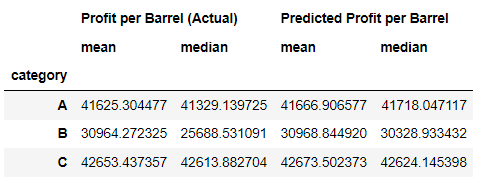

Статистические данные по объему запасов тыс. баррелей

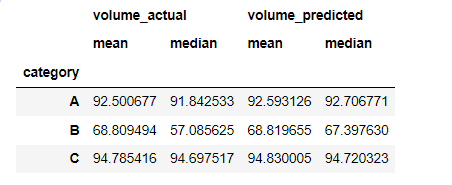

## Расчёт прибыли и рисков 

In [99]:
print('Среднее значение предсказанного объема для региона А:', 
      standart_data[standart_data['category']=='A']['volume_predicted'].mean(), 'тыс. баррелей')


Среднее значение предсказанного объема для региона А: 92.5931257269285 тыс. баррелей


In [100]:
print('Среднее значение предсказанного объема для региона B:', 
      standart_data[standart_data['category']=='B']['volume_predicted'].mean(), 'тыс. баррелей')

Среднее значение предсказанного объема для региона B: 68.81965537756679 тыс. баррелей


In [101]:
print('Среднее значение предсказанного объема для региона С:', 
      standart_data[standart_data['category']=='C']['volume_predicted'].mean(), 'тыс. баррелей')

Среднее значение предсказанного объема для региона С: 94.83000527415894 тыс. баррелей


In [102]:
#CONSTANTS
BUDGET=10_000_000_000
SAMPLE = 500
BEST_SAMPLE = 200
PRICE_POINT_MIN=BUDGET/SAMPLE #минимальная цена точки
PRICE_POINT_MAX=BUDGET/BEST_SAMPLE #максимальная цена точки
 #выборка 500 точек
 #выборка 200 лучших точек
BARREL_PRICE = 450 # цена барреля
 #бюджет
PRODUCT_VOLUME_MIN=PRICE_POINT_MIN/BARREL_PRICE
PRODUCT_VOLUME_MAX=PRICE_POINT_MAX/BARREL_PRICE
PRODUCT_VOLUME_MIN_SUM=PRODUCT_VOLUME_MIN*SAMPLE

PRODUCT_VOLUME_MAX_SUM=PRODUCT_VOLUME_MAX*BEST_SAMPLE


In [103]:
def revenue(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    
    return (selected.sum() * BARREL_PRICE * 1000) - BUDGET

state = np.random.RandomState(12345)
def bootstrap_1000(df_target, df_predicted):
    values = []
    lost = 0
    for i in range(1000):
        target_sample = df_target.sample(replace=True, random_state=state, n=SAMPLE)
        probs_sample = df_predicted[target_sample.index]
        profit = revenue(target_sample, probs_sample, BEST_SAMPLE)
        if profit < 0:
            lost += 1
        values.append(profit)
    
    values = pd.Series(values)
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    average = values.mean()
    risk = (values < 0).mean() * 100 
    return average, lower, upper, risk


In [104]:
# Подготовили таргеты и предикты по регионам
# Регион А
a_target = pd.Series(standart_data[standart_data['category'] == 'A']['crops'], 
                     index=standart_data[standart_data['category'] == 'A'].index)
a_predicted = pd.Series(standart_data[standart_data['category'] == 'A']['crops_predicted'],
                        index=standart_data[standart_data['category'] == 'A'].index)
# Регион B
b_target = pd.Series(standart_data[standart_data['category'] == 'B']['crops'],
                     index=standart_data[standart_data['category'] == 'B'].index)
b_predicted = pd.Series(standart_data[standart_data['category'] == 'B']['crops_predicted'],
                        index=standart_data[standart_data['category'] == 'B'].index)
# Регион С
c_target = pd.Series(standart_data[standart_data['category'] == 'C']['crops'],
                     index=standart_data[standart_data['category'] == 'C'].index)
c_predicted = pd.Series(standart_data[standart_data['category'] == 'C']['crops_predicted'],
                        index=standart_data[standart_data['category'] == 'C'].index)


In [105]:
#Подготовили таргеты и предикты по регионам 

A = pd.DataFrame([bootstrap_1000(a_target, a_predicted)], columns=['mean', 'lower', 'upper', 'risk'])
B = pd.DataFrame([bootstrap_1000(b_target, b_predicted)], columns=['mean', 'lower', 'upper', 'risk'])
C = pd.DataFrame([bootstrap_1000(c_target, c_predicted)], columns=['mean', 'lower', 'upper', 'risk'])


In [106]:
def number(df):
    df['mean']=df['mean']/1000
    df['lower']=df['lower']/1000
    df['upper']=df['upper']/1000
    df['risk']=df['risk']
    df.columns=['Cреднее значение прогнозируемой прибыли, тыс.руб.',
                'Нижняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.',
                'Верхняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.','Процент риска, %']
    pd.set_option('max_rows', 5)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', '{:.2f}'.format)
    return display(df)

In [107]:
print('Регион А')
number(A)
print('Регион B')
number(B)
print('Регион C')
number(C)


Регион А


,"Cреднее значение прогнозируемой прибыли, тыс.руб.","Нижняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.","Верхняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.","Процент риска, %"
0,4606138658.19,4373511845.21,4828632827.20,0.00


Регион B


,"Cреднее значение прогнозируемой прибыли, тыс.руб.","Нижняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.","Верхняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.","Процент риска, %"
0,4691247239.72,4505163249.38,4878344521.33,0.00


Регион C


,"Cреднее значение прогнозируемой прибыли, тыс.руб.","Нижняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.","Верхняя граница 95% доверительного интервала прогнозируемой прибыли, тыс.руб.","Процент риска, %"
0,4640130315.00,4388747761.23,4857098339.66,0.00


Очевидно, что все регионы пригодны для разработки по среднему, так как оно лежит между min-max по условию безубыточности по объему скважины. 
Регион С имеет наибольшее значение предсказанного  среднего объема скважины.
Разработку целесообразно вести во всех трех регионах

## Итоговый вывод

В ходе анализа данных и построения моделей для трех регионов (A, B и C) мы пришли к следующим выводам:

1. **Подготовка данных:** Провели анализ данных и выявили различия между регионами в распределении признаков. Задачей было построение модели классификации для определения категорий скважин (A, B или C) в каждом регионе. Выбранные признаки для моделирования включают числовые (f0, f1, f2, product) и категориальный (category) признаки.

2. **Корреляционный анализ:** Провели корреляционный анализ для каждого региона и выявили зависимости между признаками. Эти зависимости будут учтены при построении моделей.

3. **Обучение модели:** Построили модель классификации для каждого региона, используя подготовленные данные. Для оценки качества модели мы использовали метрики MSE, RMSE, R-squared и MAE.

4. **Сравнение с Dummy-моделью:** Cравнили качество нашей модели с Dummy-моделью и выявили, что наша модель показывает более точные и объяснимые предсказания.

5. **Интерпретация метрик:** Метрики качества модели и Dummy-модели были проинтерпретированы. Наша модель позволяет более точно предсказывать категории скважин и имеет потенциал для принятия решений при разработке региона.

6. **Итоговое решение:** Рекомендуем разработку нефтяных скважин во всех трех регионах (A, B и C), так как средний объем продукции позволяет окупить бюджет разработки, при условии, что стоимость барреля нефти составляет 450 рублей. Наша модель поможет определить наиболее перспективные скважины для разработки, что позволит максимизировать прибыль и снизить риски убытков.

Итак, наше исследование предоставляет рекомендации по выбору регионов для добычи нефти и позволяет оптимизировать процесс разработки с учетом ограниченных бюджетных ресурсов и экономических факторов.